# Import Required Libraries
Import the necessary libraries, including TensorFlow, SMAC, and other dependencies.

In [1]:
import os
import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from ConfigSpace import Configuration, ConfigurationSpace
from smac import HyperparameterOptimizationFacade, Scenario

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

2024-11-22 22:09:54.044404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732309794.054599   65330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732309794.057553   65330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 22:09:54.069027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


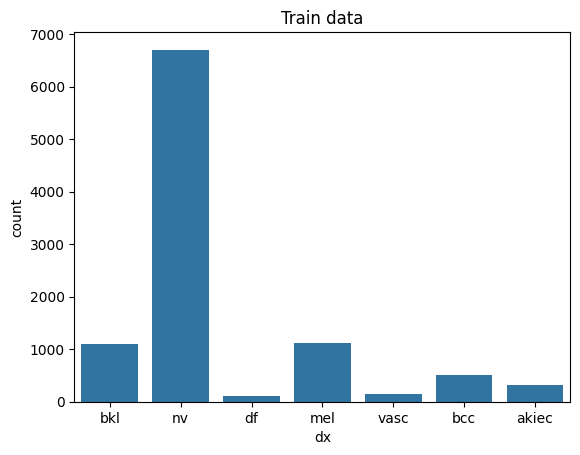

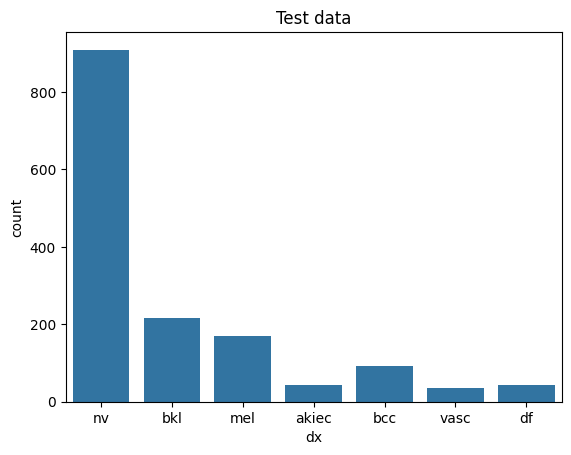

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=seed)
train_df = train_df.sample(frac=0.8, random_state=seed).reset_index(drop=True)

# Check for data leaks

In [3]:
# Extract only the image name and extension for each set
train_set = set(os.path.basename(path) for path in train_df['image_path'])
val_set = set(os.path.basename(path) for path in val_df['image_path'])
test_set = set(os.path.basename(path) for path in test_df['image_path'])

# print the path of the first image in the training set and the test set
print("First image in the training set:", list(train_set)[0])
print("First image in the test set:", list(test_set)[0])



print("Overlaps between train and validation:", len(train_set.intersection(val_set)))
print("Overlaps between train and test:", len(train_set.intersection(test_set)))
print("Overlaps between validation and test:", len(val_set.intersection(test_set)))

First image in the training set: ISIC_0033093.jpg
First image in the test set: ISIC_0034779.jpg
Overlaps between train and validation: 0
Overlaps between train and test: 0
Overlaps between validation and test: 0


# Convert label to string for API compatibility

In [4]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Load and Augment Images and create tf.Data.Dataset instances for all parts of the data

In [5]:
image_size = (128, 128)
batch_size = 64
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    print(len(df))
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
# test_dataset = create_dataset(test_df, batch_size=batch_size)


7210
1002


I0000 00:00:1732309796.417079   65330 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


# Define the CNN Model
Define the CNN model architecture using TensorFlow/Keras.

In [6]:
# Define the CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(config: Configuration):
    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    model.add(Conv2D(
        filters=config['conv_1_filters'],
        kernel_size=(2, 2),
        activation=config['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=config['conv_2_filters'],
        kernel_size=(2, 2),
        activation=config['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=config['conv_3_filters'],
        kernel_size=(2, 2),
        activation=config['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(
        units=config['dense_units'],
        activation=config['activation']))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model


# Define the Configuration Space
Define the hyperparameter search space using ConfigSpace.

In [7]:
from ConfigSpace import Categorical, ConfigurationSpace, Float, Integer

configspace = ConfigurationSpace()
configspace.add([
    Integer('conv_1_filters', (32, 256), default=64),
    Integer('conv_2_filters', (32, 128), default=64),
    Integer('conv_3_filters', (32, 64), default=32),
    Integer('dense_units', (64, 256), default=128),
    Float('learning_rate', (1e-4, 1e-2), default=1e-3, log=True),
    Categorical('activation', ['relu', 'tanh', 'sigmoid'], default='relu')
])

# Define the Training Function
Define the function to train the CNN model and return the validation accuracy.

In [9]:
# Define the Training Function
def train_model(config: Configuration, seed: int = seed) -> float:
    # Set the random seed for reproducibility
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
    # Build the model using the provided configuration
    model = build_model(config)
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        verbose=1
    )
    
    # Get the validation accuracy from the training history
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Return the validation accuracy as the objective value
    return 1 - val_accuracy

# Set Up and Run HPOFacade
Set up the HPOFacade with the defined configuration space and training function, and run the optimization.

In [10]:
# Set Up and Run HyperbandFacade

from smac import HyperparameterOptimizationFacade as HPOFacade

# Define the scenario
scenario = Scenario(configspace, deterministic=True, n_trials=50)

# Use HyperbandFacade for hyperparameter optimization
smac = HPOFacade(scenario, train_model)
incumbent = smac.optimize()

# Get the best model
best_model = build_model(incumbent)
best_model.summary()

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 60 to 12 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 12 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
Epoch 1/20


I0000 00:00:1732309806.631574   65440 service.cc:148] XLA service 0x7f45b000d980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732309806.631643   65440 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-22 22:10:06.658090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732309806.832165   65440 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-22 22:10:07.407349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1125', 4 bytes spill stores, 4 bytes spill loads



  6/113 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4826 - loss: 1.6740

I0000 00:00:1732309812.926057   65440 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6427 - loss: 1.2403

2024-11-22 22:10:21.728186: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng10{k2=4,k13=0,k14=2,k18=0,k23=0} for conv (f16[42,127,127,171]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[171,2,2,3]{3,2,1,0}, f16[171]{0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:10:21.731540: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.955557694s
Trying algorithm eng10{k2=4,k13=0,k14=2,k18=0,k23=0} for conv (f16[42,127,127,171]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[171,2,2,3]{3,2,1,0}, f16[171]{0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$con

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6429 - loss: 1.2391

2024-11-22 22:10:26.548094: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 22:10:26.776165: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:10:29.022154: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 180 bytes spill stores, 180 bytes spill loads

2024-11-22 22:10:29.236365: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 128 bytes spill stores, 100 bytes spill loads

2024-11-22 22:10:29.877635: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - accuracy: 0.6431 - loss: 1.2380 - val_accuracy: 0.6707 - val_loss: 0.9287
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6626 - loss: 0.9739 - val_accuracy: 0.6717 - val_loss: 0.9304
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6635 - loss: 0.9336 - val_accuracy: 0.6796 - val_loss: 0.8813
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6719 - loss: 0.8937 - val_accuracy: 0.6876 - val_loss: 0.8454
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6814 - loss: 0.8643 - val_accuracy: 0.6966 - val_loss: 0.7858
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6939 - loss: 0.8393 - val_accuracy: 0.7146 - val_loss: 0.7544
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6981 - loss: 0.8229 - val_accuracy: 0.7136 - val_loss: 0.7683
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7012 - loss: 0.8067 - val_accuracy: 0.7

2024-11-22 22:11:48.759683: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 22:11:48.885881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 360 bytes spill stores, 360 bytes spill loads

2024-11-22 22:11:49.388709: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 96 bytes spill stores, 96 bytes spill loads

2024-11-22 22:11:49.419432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 76 bytes spill stores, 76 bytes spill loads

2024-11-22 22:11:49.514435: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.4808 - loss: 3.9992 - val_accuracy: 0.6697 - val_loss: 1.1856
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6351 - loss: 1.3077 - val_accuracy: 0.6697 - val_loss: 1.1664
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6593 - loss: 1.2293 - val_accuracy: 0.6697 - val_loss: 1.1539
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6604 - loss: 1.1887 - val_accuracy: 0.6697 - val_loss: 1.1541
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6601 - loss: 1.1915 - val_accuracy: 0.6697 - val_loss: 1.1553
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6600 - loss: 1.1998 - val_accuracy: 0.6697 - val_loss: 1.1519
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6603 - loss: 1.1902 - val_accuracy: 0.6697 - val_loss: 1.1570
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6603 - loss: 1.1936 - val_accuracy: 0.66

2024-11-22 22:13:07.656892: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 128 bytes spill stores, 128 bytes spill loads

2024-11-22 22:13:07.659599: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 22:13:08.245672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:13:09.544911: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 220 bytes spill stores, 232 bytes spill loads

2024-11-22 22:13:09.564828: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.6362 - loss: 1.5142 - val_accuracy: 0.6697 - val_loss: 1.1402
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6532 - loss: 1.2596 - val_accuracy: 0.6697 - val_loss: 1.1353
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6583 - loss: 1.2091 - val_accuracy: 0.6697 - val_loss: 1.1351
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6601 - loss: 1.1925 - val_accuracy: 0.6697 - val_loss: 1.1333
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6609 - loss: 1.1856 - val_accuracy: 0.6697 - val_loss: 1.1334
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6607 - loss: 1.1695 - val_accuracy: 0.6697 - val_loss: 1.1327
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6609 - loss: 1.1734 - val_accuracy: 0.6697 - val_loss: 1.1326
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6607 - loss: 1.1678 - val_accuracy: 0.66

2024-11-22 22:14:41.421279: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 416 bytes spill stores, 420 bytes spill loads

2024-11-22 22:14:41.472185: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 140 bytes spill stores, 140 bytes spill loads

2024-11-22 22:14:41.508795: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 88 bytes spill stores, 88 bytes spill loads

2024-11-22 22:14:41.524746: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 392 bytes spill stores, 392 bytes spill loads

2024-11-22 22:14:42.167589: I external/local_xla/xla/stream_ex

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.6468 - loss: 1.2391 - val_accuracy: 0.6697 - val_loss: 0.9873
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6607 - loss: 1.0294 - val_accuracy: 0.6697 - val_loss: 0.8931
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6630 - loss: 0.9513 - val_accuracy: 0.6697 - val_loss: 0.8573
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6653 - loss: 0.9265 - val_accuracy: 0.6697 - val_loss: 0.8478
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6644 - loss: 0.9045 - val_accuracy: 0.6717 - val_loss: 0.8285
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6706 - loss: 0.8877 - val_accuracy: 0.6766 - val_loss: 0.8154
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6791 - loss: 0.8644 - val_accuracy: 0.6856 - val_loss: 0.8009
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6767 - loss: 0.8581 - val_accuracy: 0.6

2024-11-22 22:16:08.759068: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 22:16:09.352819: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 616 bytes spill stores, 696 bytes spill loads

2024-11-22 22:16:09.426613: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 428 bytes spill stores, 508 bytes spill loads

2024-11-22 22:16:11.067364: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 4 bytes spill stores, 4 bytes spill loads

2024-11-22 22:16:11.537698: I external/local_xla/xla/stream_execut

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.6378 - loss: 1.2256 - val_accuracy: 0.6697 - val_loss: 0.9343
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6587 - loss: 0.9867 - val_accuracy: 0.6707 - val_loss: 0.8608
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6668 - loss: 0.9373 - val_accuracy: 0.6737 - val_loss: 0.8338
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6715 - loss: 0.9010 - val_accuracy: 0.6796 - val_loss: 0.8090
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6782 - loss: 0.8593 - val_accuracy: 0.6906 - val_loss: 0.8030
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6848 - loss: 0.8524 - val_accuracy: 0.7006 - val_loss: 0.7688
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6931 - loss: 0.8175 - val_accuracy: 0.7176 - val_loss: 0.7452
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6995 - loss: 0.8080 - val_accuracy: 0.7

2024-11-22 22:17:35.639951: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 864 bytes spill stores, 852 bytes spill loads

2024-11-22 22:17:35.664030: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 22:17:35.770439: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 524 bytes spill stores, 680 bytes spill loads

2024-11-22 22:17:35.808064: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 188 bytes spill stores, 188 bytes spill loads

2024-11-22 22:17:35.945785: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.6188 - loss: 1.3935 - val_accuracy: 0.6697 - val_loss: 1.1357
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6590 - loss: 1.2046 - val_accuracy: 0.6697 - val_loss: 1.1342
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6611 - loss: 1.1828 - val_accuracy: 0.6697 - val_loss: 1.1372
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6606 - loss: 1.1725 - val_accuracy: 0.6697 - val_loss: 1.1357
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6600 - loss: 1.1610 - val_accuracy: 0.6697 - val_loss: 1.1382
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6599 - loss: 1.1703 - val_accuracy: 0.6697 - val_loss: 1.1369
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6609 - loss: 1.1625 - val_accuracy: 0.6697 - val_loss: 1.1355
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6613 - loss: 1.1599 - val_accuracy: 0.6

2024-11-22 22:18:50.849385: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng39{k2=14,k6=0,k12=23,k13=1,k14=0,k15=0,k17=24,k22=3} for conv (f16[104,2,2,184]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,63,63,184]{3,2,1,0}, f16[64,62,62,104]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:18:50.883528: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.965928582s
Trying algorithm eng39{k2=14,k6=0,k12=23,k13=1,k14=0,k15=0,k17=24,k22=3} for conv (f16[104,2,2,184]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,63,63,184]{3,2,1,0}, f16[64,62,62,104]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cu

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3897 - loss: 4.8477

2024-11-22 22:19:00.786602: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 336 bytes spill stores, 420 bytes spill loads

2024-11-22 22:19:00.803325: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 488 bytes spill stores, 488 bytes spill loads

2024-11-22 22:19:00.851831: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 356 bytes spill stores, 356 bytes spill loads

2024-11-22 22:19:00.897235: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 544 bytes spill stores, 536 bytes spill loads

2024-11-22 22:19:02.141326: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.3901 - loss: 4.8391 - val_accuracy: 0.6697 - val_loss: 1.1565
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6018 - loss: 1.3773 - val_accuracy: 0.6697 - val_loss: 1.1428
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6462 - loss: 1.2687 - val_accuracy: 0.6697 - val_loss: 1.1391
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6579 - loss: 1.2210 - val_accuracy: 0.6697 - val_loss: 1.1386
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6604 - loss: 1.2017 - val_accuracy: 0.6697 - val_loss: 1.1366
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6609 - loss: 1.1808 - val_accuracy: 0.6697 - val_loss: 1.1345
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6598 - loss: 1.1749 - val_accuracy: 0.6697 - val_loss: 1.1341
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6609 - loss: 1.1741 - val_accuracy: 0.66

2024-11-22 22:20:27.243952: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 84 bytes spill stores, 84 bytes spill loads

2024-11-22 22:20:27.283205: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 112 bytes spill stores, 112 bytes spill loads

2024-11-22 22:20:27.491159: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 4 bytes spill stores, 4 bytes spill loads

2024-11-22 22:20:27.670629: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 1182 bytes spill stores, 1216 bytes spill loads

2024-11-22 22:20:27.680650: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.6286 - loss: 1.1827 - val_accuracy: 0.6737 - val_loss: 0.9286
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6575 - loss: 0.9707 - val_accuracy: 0.6896 - val_loss: 0.8699
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6740 - loss: 0.9159 - val_accuracy: 0.7066 - val_loss: 0.8315
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6813 - loss: 0.8803 - val_accuracy: 0.7156 - val_loss: 0.8103
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6964 - loss: 0.8563 - val_accuracy: 0.7116 - val_loss: 0.7915
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7039 - loss: 0.8355 - val_accuracy: 0.7106 - val_loss: 0.7820
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7151 - loss: 0.8168 - val_accuracy: 0.7136 - val_loss: 0.7847
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7117 - loss: 0.8118 - val_accuracy: 0.70

2024-11-22 22:21:35.784640: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[252,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,128,128,3]{3,2,1,0}, f16[64,127,127,252]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:21:36.395594: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.611016365s
Trying algorithm eng0{} for conv (f16[252,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,128,128,3]{3,2,1,0}, f16[64,127,127,252]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

111/113 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6335 - loss: 1.1866

2024-11-22 22:21:46.767040: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng10{k2=1,k12=18,k13=0,k14=4,k15=0,k17=19,k18=1,k23=0} for conv (f16[252,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[42,127,127,252]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:21:46.776370: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.953127218s
Trying algorithm eng10{k2=1,k12=18,k13=0,k14=4,k15=0,k17=19,k18=1,k23=0} for conv (f16[252,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[42,127,127,252]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cu

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6338 - loss: 1.1860

2024-11-22 22:21:50.525286: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 40 bytes spill stores, 40 bytes spill loads

2024-11-22 22:21:50.584970: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 88 bytes spill stores, 88 bytes spill loads

2024-11-22 22:21:50.630453: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 976 bytes spill stores, 1044 bytes spill loads

2024-11-22 22:21:50.730754: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 24 bytes spill stores, 24 bytes spill loads

2024-11-22 22:21:50.979849: I external/local_xla/xla/stream_execu

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - accuracy: 0.6339 - loss: 1.1854 - val_accuracy: 0.6697 - val_loss: 0.9648
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6527 - loss: 1.0070 - val_accuracy: 0.6776 - val_loss: 0.9030
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6628 - loss: 0.9603 - val_accuracy: 0.6966 - val_loss: 0.8622
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6817 - loss: 0.9090 - val_accuracy: 0.7026 - val_loss: 0.8210
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6835 - loss: 0.8816 - val_accuracy: 0.7096 - val_loss: 0.8064
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6938 - loss: 0.8625 - val_accuracy: 0.7196 - val_loss: 0.7884
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6990 - loss: 0.8490 - val_accuracy: 0.7046 - val_loss: 0.7811
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7049 - loss: 0.8384 - val_accuracy: 0.7

2024-11-22 22:23:28.814898: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 28 bytes spill stores, 28 bytes spill loads

2024-11-22 22:23:29.062876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 432 bytes spill stores, 440 bytes spill loads

2024-11-22 22:23:29.317237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 380 bytes spill stores, 380 bytes spill loads

2024-11-22 22:23:32.336597: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 128 bytes spill stores, 128 bytes spill loads

2024-11-22 22:23:33.549526: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.5920 - loss: 3.3569 - val_accuracy: 0.6697 - val_loss: 1.1683
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6007 - loss: 1.4023 - val_accuracy: 0.6697 - val_loss: 1.1558
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6310 - loss: 1.3550 - val_accuracy: 0.6697 - val_loss: 1.1419
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6514 - loss: 1.2729 - val_accuracy: 0.6697 - val_loss: 1.1439
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6571 - loss: 1.2366 - val_accuracy: 0.6697 - val_loss: 1.1385
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6597 - loss: 1.2071 - val_accuracy: 0.6697 - val_loss: 1.1371
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6607 - loss: 1.2031 - val_accuracy: 0.6697 - val_loss: 1.1380
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6605 - loss: 1.1911 - val_accuracy: 0.6

2024-11-22 22:24:42.681361: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng10{k2=23,k12=-1,k13=0,k14=3,k15=0,k17=113,k18=1,k23=0} for conv (f16[145,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,128,128,3]{3,2,1,0}, f16[64,127,127,145]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:24:42.698744: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.953778575s
Trying algorithm eng10{k2=23,k12=-1,k13=0,k14=3,k15=0,k17=113,k18=1,k23=0} for conv (f16[145,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,128,128,3]{3,2,1,0}, f16[64,127,127,145]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6085 - loss: 1.9015

2024-11-22 22:24:53.501085: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 136 bytes spill stores, 136 bytes spill loads

2024-11-22 22:24:53.792574: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 136 bytes spill stores, 136 bytes spill loads

2024-11-22 22:24:53.900830: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 332 bytes spill stores, 336 bytes spill loads

2024-11-22 22:24:53.902598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 864 bytes spill stores, 852 bytes spill loads

2024-11-22 22:24:53.952842: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6087 - loss: 1.8989 - val_accuracy: 0.6697 - val_loss: 1.1508
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6601 - loss: 1.2009 - val_accuracy: 0.6697 - val_loss: 1.1603
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6607 - loss: 1.1957 - val_accuracy: 0.6697 - val_loss: 1.1590
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6599 - loss: 1.1910 - val_accuracy: 0.6697 - val_loss: 1.1640
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6611 - loss: 1.1926 - val_accuracy: 0.6697 - val_loss: 1.1644
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6597 - loss: 1.1974 - val_accuracy: 0.6697 - val_loss: 1.1575
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6609 - loss: 1.1939 - val_accuracy: 0.6697 - val_loss: 1.1666
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6612 - loss: 1.1961 - val_accuracy: 0.6

2024-11-22 22:26:14.430243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 72 bytes spill stores, 72 bytes spill loads

2024-11-22 22:26:14.446657: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 256 bytes spill stores, 256 bytes spill loads

2024-11-22 22:26:14.465677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 392 bytes spill stores, 396 bytes spill loads

2024-11-22 22:26:14.666425: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 84 bytes spill stores, 84 bytes spill loads

2024-11-22 22:26:15.017936: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.6261 - loss: 1.2449 - val_accuracy: 0.6697 - val_loss: 0.9149
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6616 - loss: 0.9843 - val_accuracy: 0.6697 - val_loss: 0.8571
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6642 - loss: 0.9355 - val_accuracy: 0.6687 - val_loss: 0.8298
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6629 - loss: 0.9150 - val_accuracy: 0.6786 - val_loss: 0.8112
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6729 - loss: 0.8843 - val_accuracy: 0.6816 - val_loss: 0.7891
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6780 - loss: 0.8567 - val_accuracy: 0.6906 - val_loss: 0.7791
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6846 - loss: 0.8451 - val_accuracy: 0.6946 - val_loss: 0.7629
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6888 - loss: 0.8265 - val_accuracy: 0.71

2024-11-22 22:27:28.074888: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 396 bytes spill stores, 428 bytes spill loads

2024-11-22 22:27:28.143561: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 460 bytes spill stores, 644 bytes spill loads

2024-11-22 22:27:28.209682: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 112 bytes spill stores, 112 bytes spill loads

2024-11-22 22:27:30.113479: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 156 bytes spill stores, 160 bytes spill loads

2024-11-22 22:27:30.151501: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.6434 - loss: 1.2233 - val_accuracy: 0.6707 - val_loss: 0.9148
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6633 - loss: 0.9692 - val_accuracy: 0.6747 - val_loss: 0.9198
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6658 - loss: 0.9348 - val_accuracy: 0.6856 - val_loss: 0.8480
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6793 - loss: 0.8856 - val_accuracy: 0.6906 - val_loss: 0.8016
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6942 - loss: 0.8513 - val_accuracy: 0.7026 - val_loss: 0.7623
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6980 - loss: 0.8205 - val_accuracy: 0.7146 - val_loss: 0.7524
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7162 - loss: 0.7951 - val_accuracy: 0.7236 - val_loss: 0.7361
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7156 - loss: 0.7730 - val_accuracy: 0.72

2024-11-22 22:28:36.727593: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1125', 4 bytes spill stores, 4 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6298 - loss: 1.2065

2024-11-22 22:28:48.135793: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 184 bytes spill stores, 184 bytes spill loads

2024-11-22 22:28:48.283522: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 376 bytes spill stores, 376 bytes spill loads

2024-11-22 22:28:48.344385: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 124 bytes spill stores, 124 bytes spill loads

2024-11-22 22:28:48.768039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 96 bytes spill stores, 96 bytes spill loads

2024-11-22 22:28:50.774926: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.6301 - loss: 1.2055 - val_accuracy: 0.6697 - val_loss: 0.9236
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6620 - loss: 0.9741 - val_accuracy: 0.6747 - val_loss: 0.8560
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6682 - loss: 0.9180 - val_accuracy: 0.6766 - val_loss: 0.8156
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6733 - loss: 0.8807 - val_accuracy: 0.6866 - val_loss: 0.7946
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6896 - loss: 0.8594 - val_accuracy: 0.7016 - val_loss: 0.7854
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6968 - loss: 0.8277 - val_accuracy: 0.7136 - val_loss: 0.7535
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7051 - loss: 0.8066 - val_accuracy: 0.7255 - val_loss: 0.7334
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7074 - loss: 0.7923 - val_accuracy: 0.7

2024-11-22 22:30:05.900489: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 564 bytes spill stores, 588 bytes spill loads

2024-11-22 22:30:05.996844: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 816 bytes spill stores, 840 bytes spill loads

2024-11-22 22:30:06.120969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 108 bytes spill stores, 108 bytes spill loads

2024-11-22 22:30:06.256939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 22:30:08.183131: I external/local_xla/xla/stream_ex

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.6411 - loss: 1.2396 - val_accuracy: 0.6707 - val_loss: 0.9201
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6598 - loss: 0.9955 - val_accuracy: 0.6717 - val_loss: 0.9019
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6630 - loss: 0.9396 - val_accuracy: 0.6866 - val_loss: 0.8422
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6812 - loss: 0.8974 - val_accuracy: 0.6886 - val_loss: 0.8129
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6864 - loss: 0.8675 - val_accuracy: 0.6986 - val_loss: 0.7819
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6919 - loss: 0.8240 - val_accuracy: 0.7106 - val_loss: 0.7670
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6982 - loss: 0.8247 - val_accuracy: 0.7166 - val_loss: 0.7400
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7048 - loss: 0.7922 - val_accuracy: 0.7

2024-11-22 22:31:19.577454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1125', 4 bytes spill stores, 4 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6434 - loss: 1.1684

2024-11-22 22:31:29.744155: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 22:31:29.747447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 128 bytes spill stores, 128 bytes spill loads

2024-11-22 22:31:30.480772: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:31:32.331733: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 220 bytes spill stores, 232 bytes spill loads

2024-11-22 22:31:32.341358: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.6435 - loss: 1.1678 - val_accuracy: 0.6697 - val_loss: 0.9432
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6593 - loss: 0.9849 - val_accuracy: 0.6717 - val_loss: 0.9402
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6664 - loss: 0.9472 - val_accuracy: 0.6766 - val_loss: 0.8841
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6692 - loss: 0.8975 - val_accuracy: 0.6886 - val_loss: 0.8172
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6865 - loss: 0.8742 - val_accuracy: 0.6976 - val_loss: 0.7875
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6882 - loss: 0.8445 - val_accuracy: 0.7016 - val_loss: 0.7746
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6904 - loss: 0.8218 - val_accuracy: 0.7196 - val_loss: 0.7402
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7042 - loss: 0.8009 - val_accuracy: 0.72

2024-11-22 22:32:47.505838: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 76 bytes spill stores, 76 bytes spill loads

2024-11-22 22:32:47.512194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 204 bytes spill stores, 204 bytes spill loads

2024-11-22 22:32:47.680518: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 112 bytes spill stores, 112 bytes spill loads

2024-11-22 22:32:47.805529: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 520 bytes spill stores, 628 bytes spill loads

2024-11-22 22:32:47.822788: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.6286 - loss: 1.2254 - val_accuracy: 0.6717 - val_loss: 0.9217
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6594 - loss: 0.9873 - val_accuracy: 0.6687 - val_loss: 0.9122
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6683 - loss: 0.9327 - val_accuracy: 0.6756 - val_loss: 0.8992
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6695 - loss: 0.9000 - val_accuracy: 0.6866 - val_loss: 0.8049
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6866 - loss: 0.8670 - val_accuracy: 0.7036 - val_loss: 0.7810
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6901 - loss: 0.8565 - val_accuracy: 0.7116 - val_loss: 0.7606
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7012 - loss: 0.8149 - val_accuracy: 0.7265 - val_loss: 0.7559
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7026 - loss: 0.8005 - val_accuracy: 0.7

2024-11-22 22:34:12.133824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 22:34:12.139440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 128 bytes spill stores, 128 bytes spill loads

2024-11-22 22:34:12.990690: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:34:15.114988: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 276 bytes spill stores, 220 bytes spill loads

2024-11-22 22:34:15.126225: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.6486 - loss: 1.2248 - val_accuracy: 0.6697 - val_loss: 0.9283
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6614 - loss: 1.0004 - val_accuracy: 0.6707 - val_loss: 0.9012
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6677 - loss: 0.9391 - val_accuracy: 0.6717 - val_loss: 0.8626
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6672 - loss: 0.8949 - val_accuracy: 0.6906 - val_loss: 0.8402
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6796 - loss: 0.8707 - val_accuracy: 0.6986 - val_loss: 0.7807
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6943 - loss: 0.8596 - val_accuracy: 0.7006 - val_loss: 0.7771
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7007 - loss: 0.8210 - val_accuracy: 0.7216 - val_loss: 0.7458
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7018 - loss: 0.8230 - val_accuracy: 0.7

2024-11-22 22:35:40.968348: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 300 bytes spill stores, 304 bytes spill loads

2024-11-22 22:35:41.078499: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 944 bytes spill stores, 944 bytes spill loads

2024-11-22 22:35:41.169636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 22:35:41.280955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 436 bytes spill stores, 440 bytes spill loads

2024-11-22 22:35:41.323476: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.6376 - loss: 1.2096 - val_accuracy: 0.6717 - val_loss: 0.9289
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6627 - loss: 0.9812 - val_accuracy: 0.6717 - val_loss: 0.9058
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6644 - loss: 0.9466 - val_accuracy: 0.6846 - val_loss: 0.8320
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6732 - loss: 0.8993 - val_accuracy: 0.6896 - val_loss: 0.8077
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6828 - loss: 0.8679 - val_accuracy: 0.7076 - val_loss: 0.7792
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6966 - loss: 0.8438 - val_accuracy: 0.7126 - val_loss: 0.7804
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6998 - loss: 0.8202 - val_accuracy: 0.7136 - val_loss: 0.7718
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7095 - loss: 0.8121 - val_accuracy: 0.7

2024-11-22 22:37:11.873887: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 136 bytes spill stores, 136 bytes spill loads

2024-11-22 22:37:11.954517: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 544 bytes spill stores, 536 bytes spill loads

2024-11-22 22:37:12.061663: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 436 bytes spill stores, 440 bytes spill loads

2024-11-22 22:37:12.179136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:37:12.274394: I external/local_xla/xla/strea

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.6391 - loss: 1.2141 - val_accuracy: 0.6697 - val_loss: 0.9221
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6583 - loss: 0.9813 - val_accuracy: 0.6766 - val_loss: 0.8583
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6721 - loss: 0.9088 - val_accuracy: 0.6856 - val_loss: 0.8412
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6764 - loss: 0.8916 - val_accuracy: 0.6946 - val_loss: 0.7797
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6887 - loss: 0.8492 - val_accuracy: 0.7016 - val_loss: 0.7698
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6958 - loss: 0.8179 - val_accuracy: 0.7066 - val_loss: 0.7546
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7067 - loss: 0.8036 - val_accuracy: 0.7236 - val_loss: 0.7318
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7106 - loss: 0.7808 - val_accuracy: 0.73

2024-11-22 22:38:24.927187: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 84 bytes spill stores, 84 bytes spill loads

2024-11-22 22:38:25.064758: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 172 bytes spill stores, 172 bytes spill loads

2024-11-22 22:38:25.080133: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 16 bytes spill stores, 16 bytes spill loads

2024-11-22 22:38:25.086153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 116 bytes spill stores, 116 bytes spill loads

2024-11-22 22:38:25.115938: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6225 - loss: 2.0446 - val_accuracy: 0.6697 - val_loss: 1.1667
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6348 - loss: 1.3114 - val_accuracy: 0.6697 - val_loss: 1.1407
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6511 - loss: 1.2592 - val_accuracy: 0.6697 - val_loss: 1.1402
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6572 - loss: 1.2262 - val_accuracy: 0.6697 - val_loss: 1.1369
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6602 - loss: 1.2069 - val_accuracy: 0.6697 - val_loss: 1.1345
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6608 - loss: 1.1943 - val_accuracy: 0.6697 - val_loss: 1.1344
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6597 - loss: 1.1917 - val_accuracy: 0.6697 - val_loss: 1.1347
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6609 - loss: 1.1827 - val_accuracy: 0.66

2024-11-22 22:39:53.592749: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=2,k3=0} for conv (f16[42,63,63,240]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,62,62,40]{3,2,1,0}, f16[40,2,2,240]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:39:53.619087: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.973042218s
Trying algorithm eng2{k2=2,k3=0} for conv (f16[42,63,63,240]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,62,62,40]{3,2,1,0}, f16[40,2,2,240]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6013 - loss: 1.8759

2024-11-22 22:39:57.479478: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 992 bytes spill stores, 1064 bytes spill loads

2024-11-22 22:39:57.617039: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 156 bytes spill stores, 156 bytes spill loads

2024-11-22 22:39:57.700782: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 448 bytes spill stores, 444 bytes spill loads

2024-11-22 22:39:57.755669: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 36 bytes spill stores, 36 bytes spill loads

2024-11-22 22:39:57.793046: I external/local_xla/xla/stream_e

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - accuracy: 0.6015 - loss: 1.8735 - val_accuracy: 0.6697 - val_loss: 1.1648
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6586 - loss: 1.2251 - val_accuracy: 0.6697 - val_loss: 1.1507
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6604 - loss: 1.1887 - val_accuracy: 0.6697 - val_loss: 1.1441
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6600 - loss: 1.1814 - val_accuracy: 0.6697 - val_loss: 1.1421
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6613 - loss: 1.1759 - val_accuracy: 0.6697 - val_loss: 1.1405
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6598 - loss: 1.1759 - val_accuracy: 0.6697 - val_loss: 1.1400
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.6599 - loss: 1.1837 - val_accuracy: 0.6697 - val_loss: 1.1428
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6602 - loss: 1.1776 - val_accuracy: 0.6

2024-11-22 22:42:49.511606: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng10{k2=0,k13=1,k14=2,k18=0,k23=0} for conv (f16[64,62,62,35]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,63,63,180]{3,2,1,0}, f16[35,2,2,180]{3,2,1,0}, f16[35]{0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 22:42:49.520356: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.946891602s
Trying algorithm eng10{k2=0,k13=1,k14=2,k18=0,k23=0} for conv (f16[64,62,62,35]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,63,63,180]{3,2,1,0}, f16[35,2,2,180]{3,2,1,0}, f16[35]{0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasA

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.6372 - loss: 1.2437 - val_accuracy: 0.6707 - val_loss: 0.9498
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6607 - loss: 0.9792 - val_accuracy: 0.6707 - val_loss: 0.9013
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6639 - loss: 0.9332 - val_accuracy: 0.6806 - val_loss: 0.8447
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6777 - loss: 0.8778 - val_accuracy: 0.6866 - val_loss: 0.8147
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6917 - loss: 0.8613 - val_accuracy: 0.6976 - val_loss: 0.7740
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6950 - loss: 0.8377 - val_accuracy: 0.7106 - val_loss: 0.7655
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6996 - loss: 0.8105 - val_accuracy: 0.7046 - val_loss: 0.7564
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7065 - loss: 0.7984 - val_accuracy: 0.72

2024-11-22 22:46:45.807996: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 92 bytes spill stores, 92 bytes spill loads

2024-11-22 22:46:45.808649: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 22:46:46.084930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 632 bytes spill stores, 628 bytes spill loads

2024-11-22 22:46:46.663890: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 788 bytes spill stores, 808 bytes spill loads

2024-11-22 22:46:47.794855: I external/local_xla/xla/stream_ex

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.6044 - loss: 1.4591 - val_accuracy: 0.6697 - val_loss: 1.1343
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6593 - loss: 1.2023 - val_accuracy: 0.6697 - val_loss: 1.1355
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.6602 - loss: 1.1868 - val_accuracy: 0.6697 - val_loss: 1.1348
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6605 - loss: 1.1757 - val_accuracy: 0.6697 - val_loss: 1.1359
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6609 - loss: 1.1697 - val_accuracy: 0.6697 - val_loss: 1.1342
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6609 - loss: 1.1638 - val_accuracy: 0.6697 - val_loss: 1.1360
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6603 - loss: 1.1676 - val_accuracy: 0.6697 - val_loss: 1.1346
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6613 - loss: 1.1676 - val_accuracy: 0.66

2024-11-22 22:48:12.486122: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 256 bytes spill stores, 260 bytes spill loads

2024-11-22 22:48:12.528598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 428 bytes spill stores, 432 bytes spill loads

2024-11-22 22:48:12.924244: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 108 bytes spill stores, 108 bytes spill loads

2024-11-22 22:48:12.924824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 928 bytes spill stores, 928 bytes spill loads

2024-11-22 22:48:13.197990: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.6100 - loss: 2.0267 - val_accuracy: 0.6697 - val_loss: 1.1546
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6569 - loss: 1.2028 - val_accuracy: 0.6697 - val_loss: 1.1466
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6606 - loss: 1.1952 - val_accuracy: 0.6697 - val_loss: 1.1424
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6604 - loss: 1.1861 - val_accuracy: 0.6697 - val_loss: 1.1434
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6596 - loss: 1.1849 - val_accuracy: 0.6697 - val_loss: 1.1456
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6599 - loss: 1.1897 - val_accuracy: 0.6697 - val_loss: 1.1433
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6600 - loss: 1.1799 - val_accuracy: 0.6697 - val_loss: 1.1463
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6600 - loss: 1.1836 - val_accuracy: 0.6

2024-11-22 22:49:33.969622: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 40 bytes spill stores, 40 bytes spill loads

2024-11-22 22:49:34.116880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 36 bytes spill stores, 36 bytes spill loads

2024-11-22 22:49:34.256481: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 148 bytes spill stores, 148 bytes spill loads

2024-11-22 22:49:34.652962: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 432 bytes spill stores, 440 bytes spill loads

2024-11-22 22:49:34.712832: I external/local_xla/xla/stream_ex

113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.6147 - loss: 1.3845 - val_accuracy: 0.6697 - val_loss: 1.1351
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6597 - loss: 1.1933 - val_accuracy: 0.6697 - val_loss: 1.1362
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6601 - loss: 1.1792 - val_accuracy: 0.6697 - val_loss: 1.1349
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6615 - loss: 1.1720 - val_accuracy: 0.6697 - val_loss: 1.1342
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6603 - loss: 1.1698 - val_accuracy: 0.6697 - val_loss: 1.1348
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6605 - loss: 1.1633 - val_accuracy: 0.6697 - val_loss: 1.1337
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6606 - loss: 1.1693 - val_accuracy: 0.6697 - val_loss: 1.1342
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6608 - loss: 1.1659 - val_accuracy: 0.66

2024-11-22 22:51:07.351157: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 112 bytes spill stores, 112 bytes spill loads

2024-11-22 22:51:07.450802: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 460 bytes spill stores, 644 bytes spill loads

2024-11-22 22:51:07.453319: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 396 bytes spill stores, 428 bytes spill loads

2024-11-22 22:51:10.464881: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 156 bytes spill stores, 160 bytes spill loads

2024-11-22 22:51:10.528564: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.6274 - loss: 5.3078 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6604 - loss: 5.4741 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6609 - loss: 5.4661 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6604 - loss: 5.4740 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.6603 - loss: 5.4749 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6604 - loss: 5.4731 - val_accuracy: 0.6

2024-11-22 22:53:26.309270: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 352 bytes spill stores, 352 bytes spill loads

2024-11-22 22:53:26.535710: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 22:53:26.597613: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 172 bytes spill stores, 240 bytes spill loads

2024-11-22 22:53:26.653044: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 60 bytes spill stores, 64 bytes spill loads

2024-11-22 22:53:26.858559: I external/local_xla/xla/stream_execut

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 162ms/step - accuracy: 0.6240 - loss: 2.1421 - val_accuracy: 0.6697 - val_loss: 0.9607
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6601 - loss: 1.0461 - val_accuracy: 0.6737 - val_loss: 0.8964
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.6653 - loss: 0.9770 - val_accuracy: 0.6866 - val_loss: 0.8914
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6778 - loss: 0.9313 - val_accuracy: 0.6966 - val_loss: 0.8340
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.6791 - loss: 0.8985 - val_accuracy: 0.6926 - val_loss: 0.8149
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6953 - loss: 0.8798 - val_accuracy: 0.7006 - val_loss: 0.8252
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6923 - loss: 0.8600 - val_accuracy: 0.6936 - val_loss: 0.8059
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.7099 - loss: 0.8064 - val_accuracy: 0.

2024-11-22 22:56:37.771773: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 22:56:38.133936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 248 bytes spill stores, 248 bytes spill loads

2024-11-22 22:56:41.040618: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 180 bytes spill stores, 180 bytes spill loads

2024-11-22 22:56:41.619220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 52 bytes spill stores, 52 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.6187 - loss: 1.8269 - val_accuracy: 0.6697 - val_loss: 1.0032
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6603 - loss: 1.0587 - val_accuracy: 0.6697 - val_loss: 0.9152
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.6584 - loss: 1.0009 - val_accuracy: 0.6697 - val_loss: 0.8955
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6591 - loss: 0.9716 - val_accuracy: 0.6697 - val_loss: 0.8804
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6602 - loss: 0.9617 - val_accuracy: 0.6697 - val_loss: 0.8760
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6601 - loss: 0.9535 - val_accuracy: 0.6697 - val_loss: 0.9804
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6610 - loss: 0.9886 - val_accuracy: 0.6697 - val_loss: 0.8648
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6642 - loss: 0.9129 - val_accuracy: 0

2024-11-22 22:59:53.692541: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 208 bytes spill stores, 208 bytes spill loads

2024-11-22 22:59:53.724944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 24 bytes spill stores, 24 bytes spill loads

2024-11-22 22:59:54.061821: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 22:59:54.093671: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 264 bytes spill stores, 264 bytes spill loads

2024-11-22 22:59:54.154773: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 170ms/step - accuracy: 0.6375 - loss: 1.2395 - val_accuracy: 0.6697 - val_loss: 0.9405
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6603 - loss: 1.0276 - val_accuracy: 0.6697 - val_loss: 0.8953
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.6629 - loss: 0.9782 - val_accuracy: 0.6697 - val_loss: 0.8820
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.6664 - loss: 0.9356 - val_accuracy: 0.6747 - val_loss: 0.8477
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6763 - loss: 0.8932 - val_accuracy: 0.6926 - val_loss: 0.8191
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6876 - loss: 0.8586 - val_accuracy: 0.6956 - val_loss: 0.7768
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6991 - loss: 0.8161 - val_accuracy: 0.7056 - val_loss: 0.7814
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.7073 - loss: 0.7901 - val_accuracy: 0

2024-11-22 23:03:08.738222: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 44 bytes spill stores, 44 bytes spill loads

2024-11-22 23:03:08.988153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 308 bytes spill stores, 308 bytes spill loads

2024-11-22 23:03:09.007758: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 432 bytes spill stores, 440 bytes spill loads

2024-11-22 23:03:11.250602: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 23:03:11.807299: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.6219 - loss: 1.3564 - val_accuracy: 0.6697 - val_loss: 0.9621
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.6604 - loss: 1.0271 - val_accuracy: 0.6697 - val_loss: 0.8958
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6593 - loss: 0.9731 - val_accuracy: 0.6697 - val_loss: 0.8483
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6614 - loss: 0.9518 - val_accuracy: 0.6727 - val_loss: 0.8552
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6625 - loss: 0.9168 - val_accuracy: 0.6747 - val_loss: 0.8371
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.6663 - loss: 0.9035 - val_accuracy: 0.6737 - val_loss: 0.8841
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6666 - loss: 0.8970 - val_accuracy: 0.6786 - val_loss: 0.8204
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6730 - loss: 0.8660 - val_accuracy: 0

2024-11-22 23:06:22.846976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 23:06:22.985292: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 23:06:23.299010: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 684 bytes spill stores, 772 bytes spill loads

2024-11-22 23:06:26.030724: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 864 bytes spill stores, 740 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.6311 - loss: 5.2983 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6604 - loss: 5.4745 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.6603 - loss: 5.4756 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6600 - loss: 5.4802 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.6603 - loss: 5.4750 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6600 - loss: 5.4803 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6590 - loss: 5.4970 - val_accuracy: 0.6

2024-11-22 23:09:03.921430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 468 bytes spill stores, 472 bytes spill loads

2024-11-22 23:09:03.946551: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 23:09:04.138094: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 416 bytes spill stores, 416 bytes spill loads

2024-11-22 23:09:04.410521: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 96 bytes spill stores, 96 bytes spill loads

2024-11-22 23:09:04.460279: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.6313 - loss: 1.2957 - val_accuracy: 0.6697 - val_loss: 0.9390
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6576 - loss: 1.0248 - val_accuracy: 0.6687 - val_loss: 0.8755
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6637 - loss: 0.9584 - val_accuracy: 0.6697 - val_loss: 0.9062
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6608 - loss: 0.9477 - val_accuracy: 0.6756 - val_loss: 0.8548
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.6693 - loss: 0.9043 - val_accuracy: 0.6776 - val_loss: 0.8230
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6687 - loss: 0.8828 - val_accuracy: 0.6896 - val_loss: 0.7960
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6931 - loss: 0.8541 - val_accuracy: 0.6936 - val_loss: 0.7771
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6975 - loss: 0.8362 - val_accuracy: 0.

2024-11-22 23:12:13.172164: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 23:12:13.396863: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 944 bytes spill stores, 1016 bytes spill loads

2024-11-22 23:12:15.475941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 60 bytes spill stores, 60 bytes spill loads

2024-11-22 23:12:15.608544: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 84 bytes spill stores, 84 bytes spill loads

2024-11-22 23:12:15.611940: I external/local_xla/xla/stream_execu

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.6277 - loss: 1.2379 - val_accuracy: 0.6697 - val_loss: 0.9400
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6622 - loss: 0.9948 - val_accuracy: 0.6707 - val_loss: 0.8672
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6668 - loss: 0.9265 - val_accuracy: 0.6747 - val_loss: 0.8495
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.6721 - loss: 0.9123 - val_accuracy: 0.6826 - val_loss: 0.8049
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6731 - loss: 0.8849 - val_accuracy: 0.6806 - val_loss: 0.7895
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6804 - loss: 0.8554 - val_accuracy: 0.6876 - val_loss: 0.7670
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6861 - loss: 0.8389 - val_accuracy: 0.6946 - val_loss: 0.7571
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.6883 - loss: 0.8136 - val_accuracy: 0

2024-11-22 23:15:18.092744: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 40 bytes spill stores, 40 bytes spill loads

2024-11-22 23:15:18.427943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 104 bytes spill stores, 104 bytes spill loads

2024-11-22 23:15:18.429607: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 836 bytes spill stores, 876 bytes spill loads

2024-11-22 23:15:18.474301: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 512 bytes spill stores, 512 bytes spill loads

2024-11-22 23:15:20.332771: I external/local_xla/xla/stream_ex

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.6377 - loss: 1.2741 - val_accuracy: 0.6697 - val_loss: 0.9303
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6628 - loss: 0.9947 - val_accuracy: 0.6707 - val_loss: 0.9319
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6675 - loss: 0.9455 - val_accuracy: 0.6836 - val_loss: 0.8381
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6725 - loss: 0.8939 - val_accuracy: 0.6866 - val_loss: 0.8346
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6827 - loss: 0.8619 - val_accuracy: 0.7066 - val_loss: 0.7885
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6989 - loss: 0.8302 - val_accuracy: 0.7136 - val_loss: 0.7537
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7098 - loss: 0.7966 - val_accuracy: 0.7305 - val_loss: 0.7600
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.7188 - loss: 0.7740 - val_accuracy: 0.

2024-11-22 23:17:52.427436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 23:17:52.481166: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 216 bytes spill stores, 216 bytes spill loads

2024-11-22 23:17:52.733763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 172 bytes spill stores, 172 bytes spill loads

2024-11-22 23:17:53.030889: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90_0', 276 bytes spill stores, 276 bytes spill loads

2024-11-22 23:17:53.149046: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6090 - loss: 1.3609 - val_accuracy: 0.6697 - val_loss: 1.1444
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.6602 - loss: 1.2062 - val_accuracy: 0.6697 - val_loss: 1.1394
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6602 - loss: 1.1943 - val_accuracy: 0.6697 - val_loss: 1.1439
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6602 - loss: 1.1982 - val_accuracy: 0.6697 - val_loss: 1.1375
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6602 - loss: 1.1854 - val_accuracy: 0.6697 - val_loss: 1.1351
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6602 - loss: 1.1878 - val_accuracy: 0.6697 - val_loss: 1.1359
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6602 - loss: 1.1862 - val_accuracy: 0.6697 - val_loss: 1.1335
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.6602 - loss: 1.1773 - val_accuracy: 0.

2024-11-22 23:20:38.685622: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 108 bytes spill stores, 108 bytes spill loads

2024-11-22 23:20:38.698417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 1064 bytes spill stores, 1200 bytes spill loads

2024-11-22 23:20:38.893304: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 724 bytes spill stores, 840 bytes spill loads

2024-11-22 23:20:40.561292: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 23:20:40.715751: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.6500 - loss: 1.2871 - val_accuracy: 0.6697 - val_loss: 0.9665
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6611 - loss: 1.0088 - val_accuracy: 0.6717 - val_loss: 0.9015
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6694 - loss: 0.9377 - val_accuracy: 0.6727 - val_loss: 0.9167
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6755 - loss: 0.9142 - val_accuracy: 0.6916 - val_loss: 0.8085
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6825 - loss: 0.8748 - val_accuracy: 0.7056 - val_loss: 0.7913
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6924 - loss: 0.8511 - val_accuracy: 0.7096 - val_loss: 0.7670
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.7057 - loss: 0.8124 - val_accuracy: 0.7176 - val_loss: 0.7625
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.7092 - loss: 0.7914 - val_accuracy: 0.

2024-11-22 23:23:16.634018: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 23:23:16.750751: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 23:23:16.811346: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 23:23:16.950956: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 1112 bytes spill stores, 1192 bytes spill loads

2024-11-22 23:23:17.166745: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.6401 - loss: 1.1633 - val_accuracy: 0.6717 - val_loss: 0.9147
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6615 - loss: 0.9770 - val_accuracy: 0.6707 - val_loss: 0.8805
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6656 - loss: 0.9173 - val_accuracy: 0.6856 - val_loss: 0.8661
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6792 - loss: 0.8812 - val_accuracy: 0.6966 - val_loss: 0.8240
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.6927 - loss: 0.8492 - val_accuracy: 0.7036 - val_loss: 0.7679
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7010 - loss: 0.8163 - val_accuracy: 0.7066 - val_loss: 0.7546
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7038 - loss: 0.7957 - val_accuracy: 0.7236 - val_loss: 0.7336
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7194 - loss: 0.7753 - val_accuracy: 0.

2024-11-22 23:25:59.711495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 23:25:59.782495: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 360 bytes spill stores, 360 bytes spill loads

2024-11-22 23:25:59.971853: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 76 bytes spill stores, 76 bytes spill loads

2024-11-22 23:25:59.989303: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 912 bytes spill stores, 912 bytes spill loads

2024-11-22 23:26:00.219264: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.6339 - loss: 1.2206 - val_accuracy: 0.6697 - val_loss: 0.9287
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6586 - loss: 0.9778 - val_accuracy: 0.6697 - val_loss: 0.9023
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6659 - loss: 0.9251 - val_accuracy: 0.6776 - val_loss: 0.8570
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6750 - loss: 0.8894 - val_accuracy: 0.6866 - val_loss: 0.8067
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6792 - loss: 0.8646 - val_accuracy: 0.6946 - val_loss: 0.7806
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.6962 - loss: 0.8387 - val_accuracy: 0.6896 - val_loss: 0.7694
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6944 - loss: 0.8139 - val_accuracy: 0.7126 - val_loss: 0.7455
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7039 - loss: 0.8019 - val_accuracy: 0

2024-11-22 23:28:47.912636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 440 bytes spill stores, 444 bytes spill loads

2024-11-22 23:28:48.123206: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 84 bytes spill stores, 84 bytes spill loads

2024-11-22 23:28:48.260528: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 112 bytes spill stores, 112 bytes spill loads

2024-11-22 23:28:48.608148: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 812 bytes spill stores, 812 bytes spill loads

2024-11-22 23:28:51.615727: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.6306 - loss: 1.2733 - val_accuracy: 0.6697 - val_loss: 0.9222
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.6600 - loss: 0.9908 - val_accuracy: 0.6697 - val_loss: 0.9071
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6698 - loss: 0.9508 - val_accuracy: 0.6687 - val_loss: 0.9100
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6685 - loss: 0.9114 - val_accuracy: 0.6776 - val_loss: 0.8431
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6756 - loss: 0.8845 - val_accuracy: 0.6916 - val_loss: 0.8611
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6841 - loss: 0.8583 - val_accuracy: 0.6876 - val_loss: 0.7875
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6907 - loss: 0.8298 - val_accuracy: 0.6906 - val_loss: 0.7863
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6967 - loss: 0.8297 - val_accuracy: 0

2024-11-22 23:31:33.152422: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 56 bytes spill stores, 56 bytes spill loads

2024-11-22 23:31:33.187050: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 23:31:33.226996: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 412 bytes spill stores, 412 bytes spill loads

2024-11-22 23:31:33.388919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 252 bytes spill stores, 252 bytes spill loads

2024-11-22 23:31:33.492353: I external/local_xla/xla/stream_exec

113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.6397 - loss: 1.2339 - val_accuracy: 0.6697 - val_loss: 0.9175
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6586 - loss: 0.9963 - val_accuracy: 0.6707 - val_loss: 0.9245
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6653 - loss: 0.9361 - val_accuracy: 0.6727 - val_loss: 0.8540
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.6673 - loss: 0.9109 - val_accuracy: 0.6776 - val_loss: 0.8084
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6841 - loss: 0.8735 - val_accuracy: 0.6946 - val_loss: 0.7879
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.6834 - loss: 0.8541 - val_accuracy: 0.6976 - val_loss: 0.7883
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.6900 - loss: 0.8274 - val_accuracy: 0.6966 - val_loss: 0.7714
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7000 - loss: 0.8200 - val_accuracy: 0.

2024-11-22 23:34:19.956433: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[227,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[42,127,127,227]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-22 23:34:20.731242: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.958783853s
Trying algorithm eng0{} for conv (f16[227,2,2,3]{3,2,1,0}, u8[0]{0}) custom-call(f16[42,128,128,3]{3,2,1,0}, f16[42,127,127,227]{3,2,1,0}), window={size=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6390 - loss: 1.1952

2024-11-22 23:34:23.334181: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 48 bytes spill stores, 48 bytes spill loads

2024-11-22 23:34:23.339361: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 156 bytes spill stores, 160 bytes spill loads

2024-11-22 23:34:23.631732: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 1160 bytes spill stores, 1248 bytes spill loads

2024-11-22 23:34:23.658257: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 32 bytes spill stores, 32 bytes spill loads

2024-11-22 23:34:23.788704: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - accuracy: 0.6392 - loss: 1.1943 - val_accuracy: 0.6707 - val_loss: 0.9363
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6602 - loss: 0.9861 - val_accuracy: 0.6707 - val_loss: 0.9156
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6651 - loss: 0.9343 - val_accuracy: 0.6856 - val_loss: 0.8835
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6732 - loss: 0.8989 - val_accuracy: 0.6916 - val_loss: 0.8212
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6890 - loss: 0.8681 - val_accuracy: 0.7006 - val_loss: 0.8123
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6948 - loss: 0.8402 - val_accuracy: 0.7016 - val_loss: 0.7741
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7027 - loss: 0.8083 - val_accuracy: 0.7056 - val_loss: 0.7572
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.7061 - loss: 0.7979 - val_accuracy: 0.

2024-11-22 23:37:20.896768: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 300 bytes spill stores, 304 bytes spill loads

2024-11-22 23:37:20.945939: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 436 bytes spill stores, 440 bytes spill loads

2024-11-22 23:37:21.058163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 944 bytes spill stores, 944 bytes spill loads

2024-11-22 23:37:21.161925: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 23:37:21.161971: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.6334 - loss: 1.2759 - val_accuracy: 0.6697 - val_loss: 0.9600
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6580 - loss: 0.9893 - val_accuracy: 0.6717 - val_loss: 0.8653
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6663 - loss: 0.9346 - val_accuracy: 0.6737 - val_loss: 0.8781
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6744 - loss: 0.8927 - val_accuracy: 0.6876 - val_loss: 0.8320
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6803 - loss: 0.8684 - val_accuracy: 0.6906 - val_loss: 0.8430
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6882 - loss: 0.8459 - val_accuracy: 0.6996 - val_loss: 0.8056
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7020 - loss: 0.8206 - val_accuracy: 0.7076 - val_loss: 0.7808
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.7054 - loss: 0.7919 - val_accuracy: 0.

2024-11-22 23:40:16.712944: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 160 bytes spill stores, 160 bytes spill loads

2024-11-22 23:40:16.776795: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 324 bytes spill stores, 328 bytes spill loads

2024-11-22 23:40:16.818307: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 672 bytes spill stores, 672 bytes spill loads

2024-11-22 23:40:16.851505: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 176 bytes spill stores, 176 bytes spill loads

2024-11-22 23:40:17.330150: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 0.6110 - loss: 5.5769 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6600 - loss: 5.4804 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6601 - loss: 5.4762 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6602 - loss: 5.4761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6598 - loss: 5.4827 - val_accuracy: 0.

2024-11-22 23:45:48.396259: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1125', 4 bytes spill stores, 4 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6467 - loss: 1.2240

2024-11-22 23:46:03.220928: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 436 bytes spill stores, 440 bytes spill loads

2024-11-22 23:46:03.308439: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 300 bytes spill stores, 304 bytes spill loads

2024-11-22 23:46:03.357740: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 944 bytes spill stores, 944 bytes spill loads

2024-11-22 23:46:03.486367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 23:46:03.745958: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.6469 - loss: 1.2230 - val_accuracy: 0.6697 - val_loss: 0.9293
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.6601 - loss: 0.9943 - val_accuracy: 0.6707 - val_loss: 0.9082
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.6645 - loss: 0.9473 - val_accuracy: 0.6786 - val_loss: 0.8488
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.6804 - loss: 0.8828 - val_accuracy: 0.6996 - val_loss: 0.7975
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.6871 - loss: 0.8594 - val_accuracy: 0.7046 - val_loss: 0.7643
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6913 - loss: 0.8342 - val_accuracy: 0.7216 - val_loss: 0.7504
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.7180 - loss: 0.7919 - val_accuracy: 0.7236 - val_loss: 0.7280
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7171 - loss: 0.7657 - val_accuracy: 0.

2024-11-22 23:49:06.595813: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 436 bytes spill stores, 440 bytes spill loads

2024-11-22 23:49:06.637027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 300 bytes spill stores, 304 bytes spill loads

2024-11-22 23:49:06.845925: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 944 bytes spill stores, 944 bytes spill loads

2024-11-22 23:49:07.160032: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 144 bytes spill stores, 144 bytes spill loads

2024-11-22 23:49:07.312788: I external/local_xla/xla/stream_

113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.6456 - loss: 1.2576 - val_accuracy: 0.6697 - val_loss: 0.9607
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6587 - loss: 1.0058 - val_accuracy: 0.6687 - val_loss: 0.9095
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6661 - loss: 0.9524 - val_accuracy: 0.6756 - val_loss: 0.9131
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.6726 - loss: 0.9129 - val_accuracy: 0.6806 - val_loss: 0.8282
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6843 - loss: 0.8749 - val_accuracy: 0.6926 - val_loss: 0.8079
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6864 - loss: 0.8634 - val_accuracy: 0.6916 - val_loss: 0.7976
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.6945 - loss: 0.8367 - val_accuracy: 0.7006 - val_loss: 0.7859
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.6993 - loss: 0.8078 - val_accuracy: 0

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_150 (Conv2D)             │ (None, 127, 127, 171)  │         2,223 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 63, 63, 171)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 62, 62, 42)     │        28,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 31, 31, 42)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 30, 30, 39)     │         6,591 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 15, 15, 39)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 8775)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 229)            │     2,009,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 229)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 7)              │         1,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,048,898 (7.82 MB)

 Trainable params: 2,048,898 (7.82 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluate the Best Model
Evaluate the best model found by HyperbandFacade on the test dataset and print the results.

In [11]:
print(incumbent)

Configuration(values={
  'activation': 'relu',
  'conv_1_filters': 171,
  'conv_2_filters': 42,
  'conv_3_filters': 39,
  'dense_units': 229,
  'learning_rate': 0.0009795606401,
})


1511
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0569 - loss: 1.9173

2024-11-23 00:04:02.781851: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 180 bytes spill stores, 180 bytes spill loads

2024-11-23 00:04:03.068806: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 128 bytes spill stores, 100 bytes spill loads

2024-11-23 00:04:03.523140: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 52 bytes spill stores, 52 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.0563 - loss: 1.9174
Test Accuracy: 0.049636002629995346


2024-11-23 00:04:05.473161: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Best model OVO AUC: 0.5153490775790887
Best model OVR AUC: 0.5153490775790887
Best model F1 Score: 0.0506177499655709


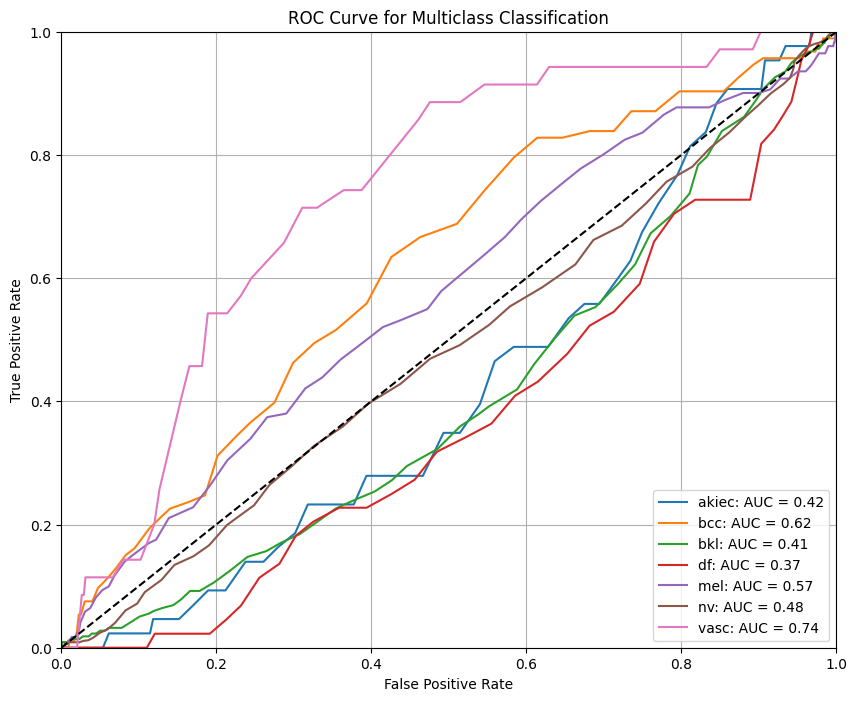

In [12]:
# Evaluate the Best Model

# Create test_dataset
test_dataset = create_dataset(test_df, batch_size=batch_size)

# Evaluate the best model on the test dataset
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

# Calculate AUC and F1 scores
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_score = best_model.predict(test_dataset)

baseline_ovo_auc = roc_auc_score(y_true, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(y_true, y_score, multi_class="ovr")
baseline_f1_score = f1_score(y_true.argmax(axis=1), y_score.argmax(axis=1), average="weighted")

print(f'Best model OVO AUC: {baseline_ovo_auc}')
print(f'Best model OVR AUC: {baseline_ovr_auc}')
print(f'Best model F1 Score: {baseline_f1_score}')

# Plot ROC curves
y_true = to_categorical(np.argmax(y_true, axis=1), num_classes)
class_names = label_encoder.inverse_transform(np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()